In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...


/opt/miniconda3/envs/python/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603740477510/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [42]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [43]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [44]:
X_train = X_train.float()
X_test = X_test.float()

In [45]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [46]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

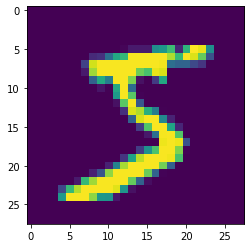

tensor(5)


In [47]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [48]:
# растянем эту картинку в один длинный вектор, и тогда каждый пиксель найдёт своё место в этом длинном векторе. 
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [49]:
# Давайте создадим такую нейронную сеть: она будет очень похожей на ту которую мы создавали для вин,
# она точно также будет состоять из нескольких полносвязанных слоёв. 
# Здесь будет их два, то есть fc1 -- это (fully connected 1) слой, на вход которому приходит 28 на 28, 
# (то есть вот эти 784 пикселя). Далее они передаются в N hidden neurons, 
# который мы можем как угодно задавать в зависимости от того, сколько нам нужно информации в скрытом слое. 
# После этого у нас будет сигмоидная активация, чтобы добавить нелинейность, и после этого, после активации, 
# результат будет передаваться в ещё один полносвязанный слой. На входе у него n hidden neurons (то же самое значение), 
# а на выходе 10 (потому, что у нас 10 классов): это цифры от 0 до 9. То есть у нас классификация на 10 классов. 
# Кроме того нужно написать функцию forward, которая пропускает тензор X через все эти слои последовательно: 
# fully connected, активация, fully connected второй, и выдаёт результирующий тензор, 
# который являет собой выходы из второго полносвязанного слоя размером 10. 
# Давайте создадим такую нейронную сеть, назовём её MNISTnet, скажем что у неё внутри 100 скрытых нейронов.

class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [50]:
torch.cuda.is_available()

False

In [51]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [52]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[ 0.0255, -0.0269, -0.0041,  ...,  0.0281,  0.0076, -0.0123],
         [-0.0196,  0.0333, -0.0029,  ...,  0.0192, -0.0170, -0.0292],
         [-0.0333, -0.0296,  0.0156,  ...,  0.0350, -0.0079,  0.0280],
         ...,
         [ 0.0340, -0.0156, -0.0035,  ..., -0.0062, -0.0263, -0.0262],
         [-0.0156, -0.0011,  0.0201,  ..., -0.0020, -0.0187,  0.0116],
         [ 0.0058,  0.0027,  0.0108,  ..., -0.0298, -0.0246,  0.0105]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0111,  0.0118,  0.0256, -0.0345,  0.0340,  0.0239,  0.0243, -0.0216,
         -0.0045,  0.0121, -0.0137,  0.0015,  0.0110,  0.0011,  0.0278,  0.0243,
          0.0039,  0.0322,  0.0351, -0.0352, -0.0090, -0.0100, -0.0172, -0.0350,
         -0.0219, -0.0132, -0.0020, -0.0202,  0.0219,  0.0080,  0.0270,  0.0219,
         -0.0120, -0.0025,  0.0289, -0.0333, -0.0318, -0.0193,  0.0249,  0.0001,
         -0.0241, -0.0061, -0.0267,  0.0185,  0.0136, -0.0038, -0.0224, -0.0018

In [53]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

Теперь нам нужно написать процесс обучения. Как и в прошлый раз, мы будем обучаться батчевым или стохастическим градиентным спуском. То есть мы будем делить наш датасет на маленькие части (так называемые батчи), передавать эти батчи в нейронную сеть с помощью функции forward. После этого мы будем вызывать loss-функцию, которая скажет нам размер ошибки. После этого мы сможем посчитать градиент с помощью функции backward, и дальше мы сможем сделать градиентный шаг, вызвав optimizer.step. То есть у нас будет batch_size размером 100 (это число, которое выбрано наугад), мы поставим 10 000 эпох, учитывая что мы можем остановить обучение в любой момент, а 10000 точно хватит. Каждый раз мы будем перемешивать датасет, на каждой эпохе и выделять оттуда последовательные участки, таким образом, чтобы внутри одной эпохи каждый элемент, каждая картинка была показана всего один раз. После этого, как я и говорил, мы у mnist_net будем вызывать функцию forward на батче, дальше будем считать loss-функцию по нашим prediction, то есть выходам нейронной сети, и по Y_batch, то есть по лейблам -- по тем классам, которые мы бы хотели, чтобы нейросеть предсказала. Далее мы можем посчитать backward, то есть посчитать градиенты, а потом мы можем сделать градиентный шаг у оптимайзера. Кроме того нам бы хотелось видеть каждую эпоху, как растет наше качество. И видеть рост этого качества лучше всего на тестовом датасете -- на тех данных, которые нейросеть не видела. Поэтому будем вызывать mnistnet.forward ещё и на тестовом датасете, на X_test. Здесь мы будем делать forward по всему тестовому датасету, предполагая, что он  не очень большой, а батчевый градиентный спуск нам нужен всего по двум причинам (вот, почему мы это делаем в трейновой части). Во-первых, потому что таким образом сам процесс оптимизации происходит быстрее -- то есть, лучше сделать 10 градиентных шагов на эпоху, чем сделать один. А во-вторых, потому что у нас могут не помещаться батчи в GPU (то есть на видео карточку), если мы будем делать их довольно большими. Я не уверен, что весь датасет (X_train) поместится на мою видеокарточку, если я буду его переносить. Поэтому мы ограничились в трейне batch_size 100, а в тесте мы предположили, что все будет нормально, в видеокарточку всё влезет, и поэтому мы можем сделать forward по всему датасету. Кроме того, нам нужно посчитать долю правильных ответов -- accuracy и, соответственно, нам нужно понять, а какой же класс предсказала нейронная сеть. Нейронная сеть предсказывает класс, для которого она выдает максимальное значение. То есть, после этого это значение отправляется в софтмакс, если нужно узнать его вероятность, но уже перед софтмаксом мы можем понять -- а какой наиболее вероятный класс предсказала нейронная сеть. Это будет тот нейрон, у которого максимальный выход. Соответственно, нам нужно сделать argmax (argmax нам отдаст номер нейрона, одного из десяти, у которого максимальный выход), и сравнить это с y_test, то есть если номер нейрона с максимальным выходом совпал с номером класса (от нуля до девяти), то значит мы все сделали правильно и, посчитав среднее количество угадываний, мы получим accuracy. Вот это accuracy мы будем каждый раз выводить на экран. Давайте запустим наш процесс обучения и посмотрим, как он работает. Видим, что работает довольно медленно, то есть эпоха происходит несколько секунд, но уже сразу после обучения одной эпохи у нас получается accuracy 90%. Понятно, что если нейронная сеть будет предсказывать случайные цифры то она будет иметь в среднем accuracy 10%, то есть наша нейронная сеть уже за одну эпоху довольно неплохо обучилась. И дальше мы будем видеть, как она каждую эпоху наращивает результаты.


In [56]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.9558)
tensor(0.9526)
tensor(0.9540)
tensor(0.9534)
tensor(0.9540)
tensor(0.9550)
tensor(0.9553)
tensor(0.9543)
tensor(0.9586)
tensor(0.9590)
tensor(0.9559)
tensor(0.9583)
tensor(0.9583)
tensor(0.9551)
tensor(0.9551)
tensor(0.9584)
tensor(0.9552)
tensor(0.9590)
tensor(0.9570)


KeyboardInterrupt: 

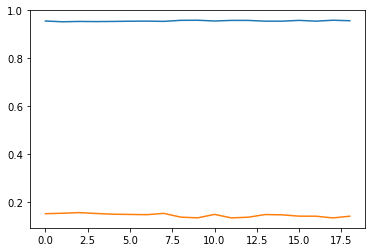

In [57]:
plt.plot(test_accuracy_history)
plt.plot(test_loss_history);

# Вопросы

Попрактикуемся с методом reshape. У нас есть трехмерный тензор размерности (6000, 28, 28) . Сопоставьте операцию над этим тензором и её результатат:

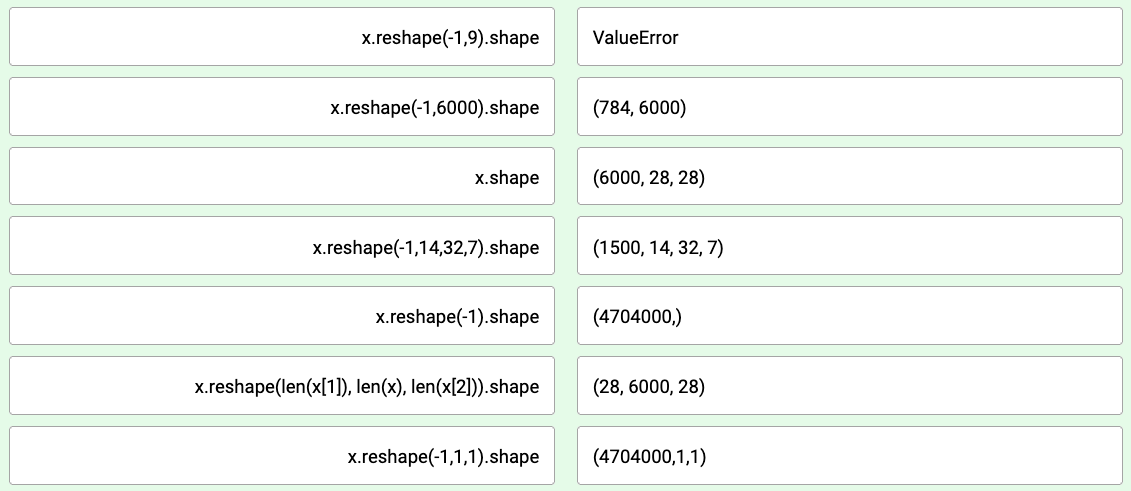

In [22]:
X_train.reshape(-1,9).shape

RuntimeError: shape '[-1, 9]' is invalid for input of size 47040000

In [23]:
X_train.reshape(-1,6000).shape

torch.Size([7840, 6000])

In [24]:
X_train.reshape(-1,14,32,7).shape

torch.Size([15000, 14, 32, 7])

In [25]:
X_train.reshape(-1).shape

torch.Size([47040000])

In [27]:
X_train.reshape(len(X_train[1]), len(X_train), len(X_train[2])).shape

torch.Size([28, 60000, 28])

In [28]:
X_train.reshape(-1,1,1).shape

torch.Size([47040000, 1, 1])

Запустите код из видео на GPU. В последнем шаге мы рисовали график accuracy и loss на валидации. А что с ними происходит на train'е?

    Постройте на одном графике loss для train и validation.
    Правда ли, что loss на train и validation падает одинаково быстро и выходит на одинаковое значение, или же у нас есть переобучение?
    Ведет ли увеличение количества эпох (40 эпох -> 200 эпох) к улучшению метрик на валидации?
    Замерьте время вычисления 100 эпох на CPU и на GPU. Какое ускорение вы наблюдаете?
    Замедляет ли torch.backends.cudnn.deterministic = True обучение на практике? Если да, то насколько?
    Попробуйте разные методы градиентного спуска, которые были в лекции. Как выбор градиентного спуска влияет на accuracy? Для уверенности лучше проводить один эксперимент 3-5 раз на разных random seed: так вы поймете, действительно ли сказывается влияние метода или дело в случайности.


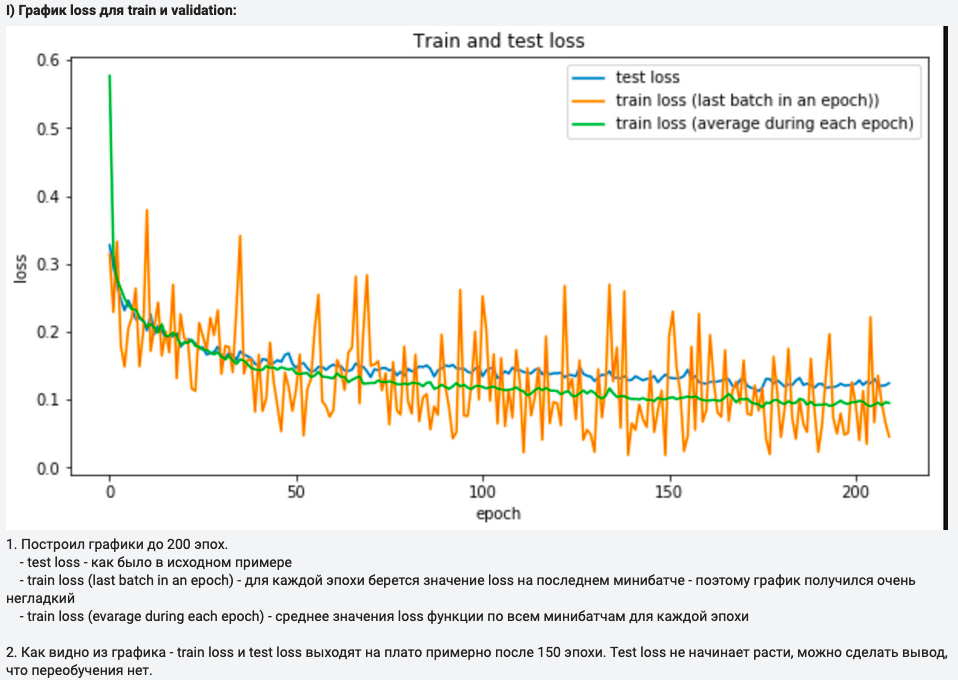

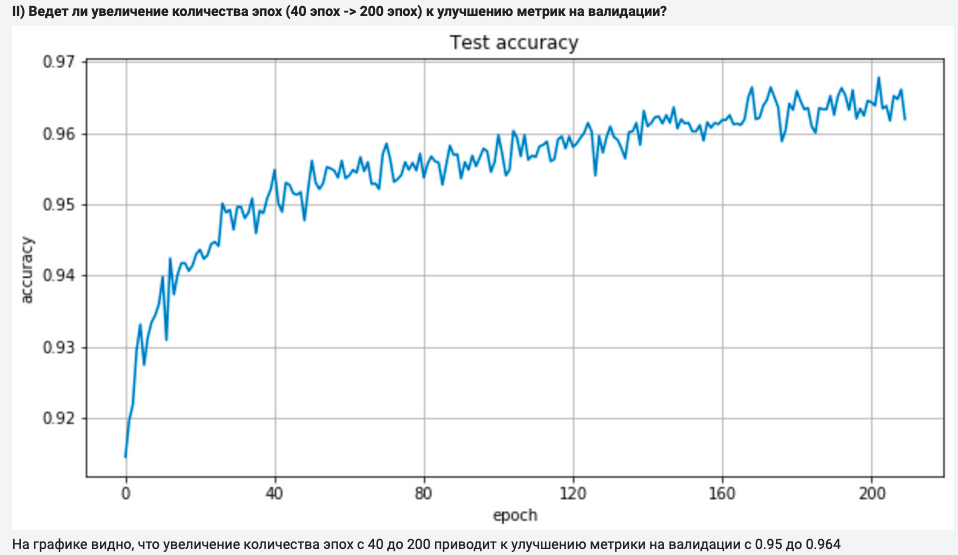

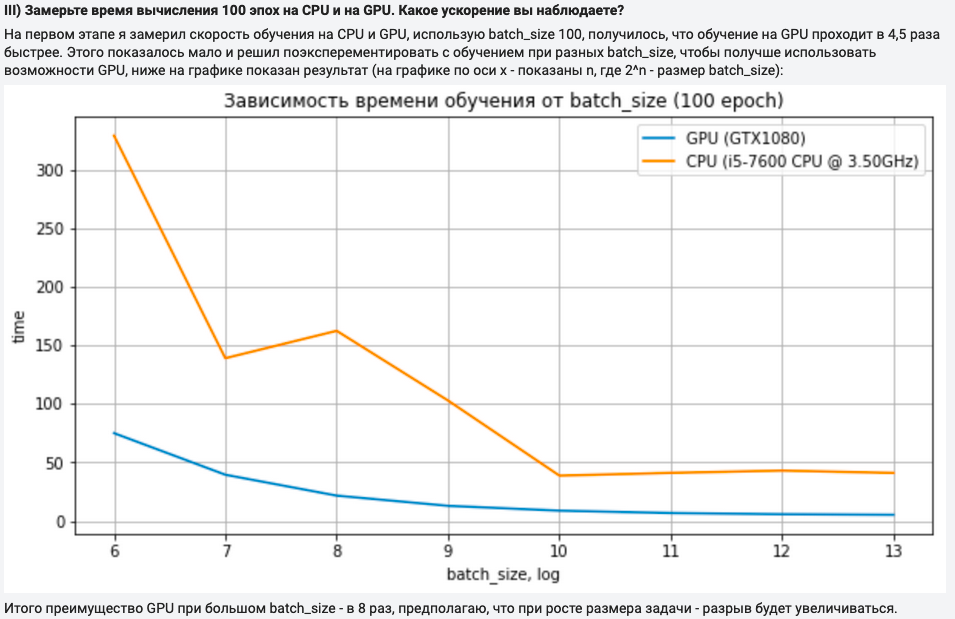

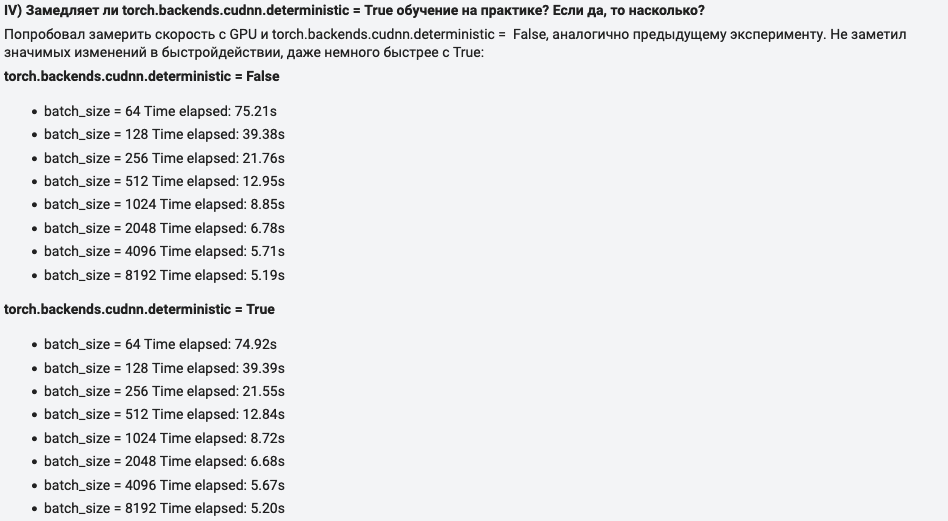

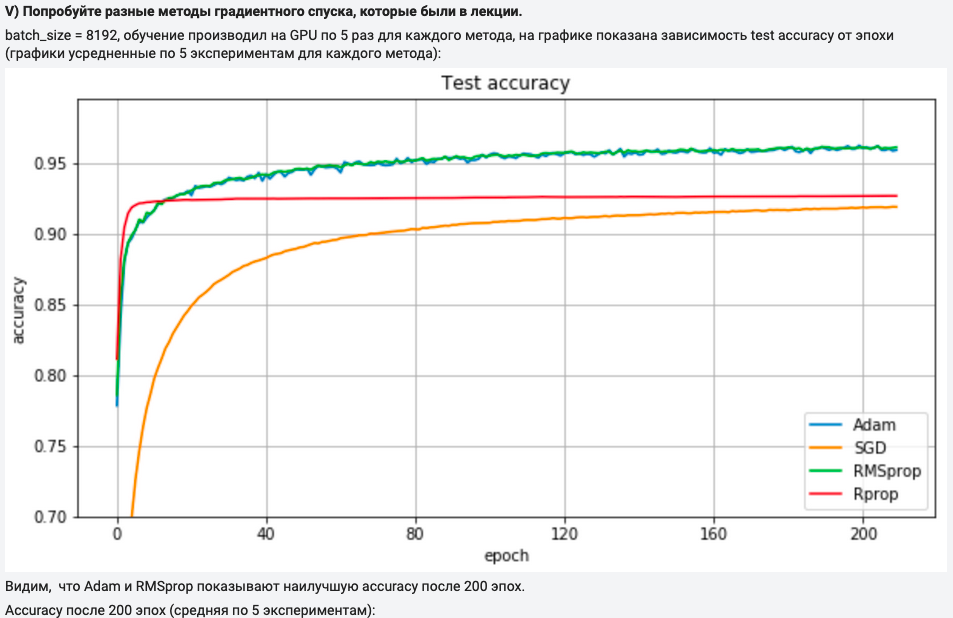


    SGD - 0.9193
    Rprop - 0.9271
    RMSprop - 0.9616
    Adam - 0.9596


In [58]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []
train_accuracy_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(200):
    order = np.random.permutation(len(X_train))
    train_preds = torch.zeros([X_train.shape[0], 10], dtype=torch.float)
    train_batch_loss_history = []

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        train_batch_loss_history.append(loss_value.tolist())
        
        train_preds[batch_indexes] = preds.cpu()
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss = loss(test_preds, y_test)
    test_loss_history.append(test_loss)
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    
    train_loss = np.mean(train_batch_loss_history)
    train_loss_history.append(train_loss)
    
    accuracy2 = (train_preds.argmax(dim=1) == y_train).float().mean()
    train_accuracy_history.append(accuracy2)

    print('{:4d} tr_loss:{:.4f} val_loss:{:.4f} tr_acc:{:.4f} val_acc:{:.4f}'.format(
        epoch,
        train_loss,
        test_loss,
        accuracy2.tolist(),
        accuracy.tolist()))

   0 tr_loss:0.1167 val_loss:0.1444 tr_acc:0.9632 val_acc:0.9568
   1 tr_loss:0.1143 val_loss:0.1379 tr_acc:0.9639 val_acc:0.9580
   2 tr_loss:0.1120 val_loss:0.1413 tr_acc:0.9651 val_acc:0.9577
   3 tr_loss:0.1151 val_loss:0.1433 tr_acc:0.9636 val_acc:0.9565
   4 tr_loss:0.1110 val_loss:0.1331 tr_acc:0.9656 val_acc:0.9608
   5 tr_loss:0.1055 val_loss:0.1348 tr_acc:0.9673 val_acc:0.9608
   6 tr_loss:0.1071 val_loss:0.1430 tr_acc:0.9674 val_acc:0.9582
   7 tr_loss:0.1119 val_loss:0.1512 tr_acc:0.9660 val_acc:0.9546
   8 tr_loss:0.1157 val_loss:0.1392 tr_acc:0.9637 val_acc:0.9597
   9 tr_loss:0.1136 val_loss:0.1340 tr_acc:0.9643 val_acc:0.9605
  10 tr_loss:0.1111 val_loss:0.1400 tr_acc:0.9646 val_acc:0.9573
  11 tr_loss:0.1114 val_loss:0.1410 tr_acc:0.9657 val_acc:0.9592
  12 tr_loss:0.1077 val_loss:0.1366 tr_acc:0.9664 val_acc:0.9604
  13 tr_loss:0.1124 val_loss:0.1369 tr_acc:0.9650 val_acc:0.9607
  14 tr_loss:0.1104 val_loss:0.1366 tr_acc:0.9653 val_acc:0.9603
  15 tr_loss:0.1102 val_l

KeyboardInterrupt: 

Как было сказано в предыдущем уроке, полносвязный слой может быть представлен как матричное умножение матрицы входов (X) и матрицы весов нейронов слоя (W), плюс вектор bias'ов слоя (b). 

В документации к классу torch.nn.Linear (полносвязному слою) написано следующее: Applies a linear transformation to the incoming data: y=xAT+by = xA^T + by=xAT+b . А здесь – это то, как PyTorch хранит веса слоя. Но чтобы эта матрица совпала с W из предыдущего урока, нужно её сперва транспонировать.

Давайте реализуем функциональность torch.nn.Linear и сверим с оригиналом!

Пусть у нас будет 1 объект x на входе с двумя компонентами. Его мы передадим в полносвязный слой с 3-мя нейронами и получим, соотсветственно, 3 выхода. После напишем эту же функциональность с помощью матричного умножения. 

In [61]:
import torch

# Сперва создадим тензор x:
x = torch.tensor([[10., 20.]])

# Оригинальный полносвязный слой с 2-мя входами и 3-мя нейронами (выходами):
fc = torch.nn.Linear(2, 3)

# Веса fc-слоя хранятся в fc.weight, а bias'ы соответственно в fc.bias
# fc.weight и fc.bias по умолчанию инициализируются случайными числами

# Давайте проставим свои значения в веса и bias'ы:
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w

b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b

# Получим выход fc-слоя:
fc_out = fc(x)

# Попробуем теперь получить аналогичные выходы с помощью матричного перемножения:
fc_out_alternative =  x @ w.t() + b # x * w^T + b

# или torch.mm(x, w.transpose(0, 1)) + b
# или torch.mm(x, w.t()) + b

# Проверка осуществляется автоматически вызовом функции
print(fc_out == fc_out_alternative)
# (раскомментируйте, если решаете задачу локально)

tensor([[True, True, True]])


В предыдущем шаге мы написали функцию, эмулирующую fc-слой. Проверим, что по ней правильно считается градиент. 

Функцию backward() в PyTorch можно посчитать только от скалярной функции (выход из такой функции – одно число). Это логично, так как loss-функция выдает всегда одно число. Но fc-слой, который мы проэмулировали, имел 3 выхода. Предлагаем их просуммировать, чтобы получить в итоге скалярную функцию. Заметим, впрочем, что можно было бы выбрать любую агрегирующую операцию, например умножение.

Дополните код так, чтобы градиент по весам и смещениям (bias) совпадал с аналогичным градиентом в вашей фунции.

Чем обусловлен полученный градиент? Изменится ли он, если мы подадим другие входы или другую инициализацию весов?

In [63]:
import torch

# Сперва создадим тензор x:
x = torch.tensor([[10., 20.]])

# Оригинальный полносвязный слой с 2-мя входами и 3-мя нейронами (выходами):
fc = torch.nn.Linear(2, 3)

# Веса fc-слоя хранятся в fc.weight, а bias'ы соответственно в fc.bias
# fc.weight и fc.bias по умолчанию инициализируются случайными числами

# Давайте проставим свои значения в веса и bias'ы:
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w

b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b

# Получим выход fc-слоя:
fc_out = fc(x)
# Просуммируем выход fc-слоя, чтобы получить скаляр:
fc_out_summed = fc_out.sum()

# Посчитаем градиенты формулы fc_out_summed:
fc_out_summed.backward()
weight_grad = fc.weight.grad
bias_grad = fc.bias.grad

# Ok, теперь воспроизведем вычисления выше но без fc-слоя:
# Проставим, что у "w" и "b" нужно вычислять градиенты (для fc-слоя это произошло автоматически):
w.requires_grad_(True)
b.requires_grad_(True)

# Получим выход нашей формулы:
our_formula = torch.sum(torch.mm(x, w.t()) + b) # SUM{x * w^T + b}

# Сделайте backward для нашей формулы:
our_formula.backward()

# Проверка осуществляется автоматически, вызовом функций:
print('fc_weight_grad:', weight_grad)
print('our_weight_grad:', w.grad)
print('fc_bias_grad:', bias_grad)
print('out_bias_grad:', b.grad)
# (раскомментируйте, если работаете над задачей локально)

fc_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
our_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
fc_bias_grad: tensor([[1., 1., 1.]])
out_bias_grad: tensor([[1., 1., 1.]])
